# <a name="0">State Farm Distracted Driver Detection</a>
## A Computer Vision Problem.
### The competition page from [this](https://www.kaggle.com/competitions/state-farm-distracted-driver-detection) link.

### Table of Contents of the notebook:

1. <a href="#1">**Libraries**</a>
2. <a href="#2">**Display Excel File**</a>
3. <a href="#3">**Split train data to train & validation**</a>
4. <a href="#4">**Display some Images**</a>
5. <a href='#5'>**Dense Layer**</a>
6. <a href='#6'>**CNN model**</a>
7. <a href="#7">**Data Augentation**</a>
8. <a href="#8">**Frozen model**</a>
9. <a href="#9">**Fine Tuning**</a>
10. <a href="#10">**Testing**</a>
11. <a href="#11">**Group names**</a>

# 1. <a name="1">**Libraries**</a>

In [16]:
!pip install --upgrade  tensorflow==2.8.0

In [17]:
!pip install split-folders

In [18]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tqdm import tqdm
import datetime

from getpass import getpass
import os
import cv2, glob

import splitfolders

from sklearn.model_selection import train_test_split

import tensorflow as tf
import tensorflow.keras as keras

from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense,Dropout
from tensorflow.keras.utils import plot_model

from tensorflow.keras.applications import VGG16, VGG19
from tensorflow.keras.applications.resnet import ResNet50
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input
from tensorflow.keras.callbacks import EarlyStopping


from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers

from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications.imagenet_utils import preprocess_input

from tensorflow.keras.applications.imagenet_utils import decode_predictions

from tensorflow.keras.models import load_model

In [19]:
keras.__version__

'2.8.0'

# 2. <a name="2">**Display Excel File**</a>

In [20]:
df = pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/driver_imgs_list.csv")
df.head()

subject classname            img
0    p002        c0  img_44733.jpg
1    p002        c0  img_72999.jpg
2    p002        c0  img_25094.jpg
3    p002        c0  img_69092.jpg
4    p002        c0  img_92629.jpg

In [21]:
df.shape

(22424, 3)

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22424 entries, 0 to 22423
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   subject    22424 non-null  object
 1   classname  22424 non-null  object
 2   img        22424 non-null  object
dtypes: object(3)
memory usage: 525.7+ KB


### 3. <a name="3">**Split train data to train & validation**</a>

In [23]:
data_dir = '/kaggle/input/state-farm-distracted-driver-detection/imgs/train'
splitfolders.ratio(data_dir, output="dataa",
    seed=1337, ratio=(.8, .2), group_prefix=None, move=False)

Copying files: 22424 files [00:45, 490.50 files/s] 


# 4. <a name="4">**Display some Images**</a>

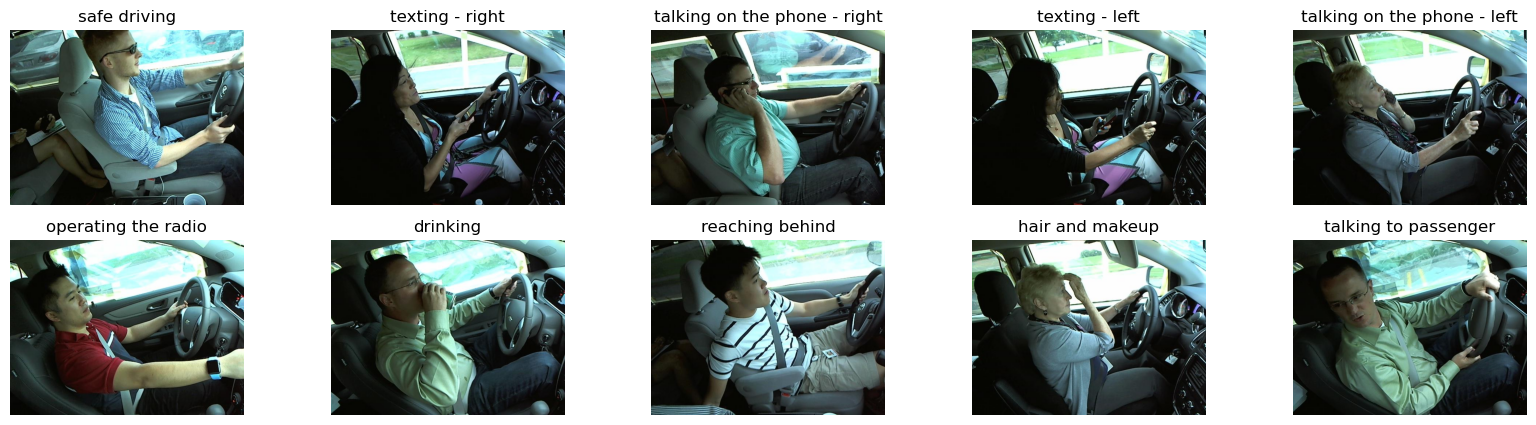

In [24]:
state = ['safe driving', 'texting - right', 'talking on the phone - right', 'texting - left', 'talking on the phone - left',
         'operating the radio', 'drinking', 'reaching behind', 'hair and makeup', 'talking to passenger', 'UNKNOWN']

def Display(path, Class=None):
    img = cv2.imread(path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    if Class == None:
        plt.figure()
        plt.title(state[10])
        plt.imshow(img)
        plt.axis("off")
        # print(img.shape)
    else:
        plt.subplot(2, 5, Class+1)
        plt.title(state[Class])
        plt.imshow(img)
        plt.axis("off")

plt.figure(figsize=(20, 5))
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c0/img_100026.jpg", 0)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c1/img_100021.jpg", 1)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c2/img_100029.jpg", 2)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c3/img_100006.jpg", 3)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c4/img_100225.jpg", 4)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c5/img_10000.jpg", 5)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c6/img_100036.jpg", 6)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c7/img_100057.jpg", 7)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c8/img_100015.jpg", 8)
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/train/c9/img_100090.jpg", 9)

# 5. <a name="5">**Dense Layer**</a>

In [25]:
dense_train_gen = ImageDataGenerator(rescale=1./255)
dense_train = dense_train_gen.flow_from_directory('/kaggle/working/dataa/train', batch_size=128, target_size= (256, 256))

dense_val_gen = ImageDataGenerator(rescale=1./255)
dense_val = dense_val_gen.flow_from_directory('/kaggle/working/dataa/val', batch_size=128, target_size= (256, 256))

Found 17934 images belonging to 10 classes.
Found 4490 images belonging to 10 classes.


In [26]:
model_dense = models.Sequential()
model_dense.add(Flatten(input_shape=(256, 256, 3)))
model_dense.add(Dense(512, activation='relu'))
model_dense.add(Dense(256, activation='relu'))
model_dense.add(Dense(128, activation='relu'))
model_dense.add(Dense(10, activation='softmax'))
model_dense.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [27]:
model_dense.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_1 (Flatten)         (None, 196608)            0         
                                                                 
 dense_4 (Dense)             (None, 512)               100663808 
                                                                 
 dense_5 (Dense)             (None, 256)               131328    
                                                                 
 dense_6 (Dense)             (None, 128)               32896     
                                                                 
 dense_7 (Dense)             (None, 10)                1290      
                                                                 
Total params: 100,829,322
Trainable params: 100,829,322
Non-trainable params: 0
_________________________________________________________________


In [28]:
history_dense = model_dense.fit(dense_train ,epochs=10,validation_data=dense_val)

Epoch 1/10
141/141 [==============================] - 142s 1s/step - loss: 12.4533 - accuracy: 0.3816 - val_loss: 0.8929 - val_accuracy: 0.7581
Epoch 2/10
141/141 [==============================] - 140s 995ms/step - loss: 0.7213 - accuracy: 0.7982 - val_loss: 0.4832 - val_accuracy: 0.8846
Epoch 3/10
141/141 [==============================] - 140s 994ms/step - loss: 0.4315 - accuracy: 0.8915 - val_loss: 0.2638 - val_accuracy: 0.9479
Epoch 4/10
141/141 [==============================] - 141s 998ms/step - loss: 0.2310 - accuracy: 0.9539 - val_loss: 0.1886 - val_accuracy: 0.9644
Epoch 5/10
141/141 [==============================] - 140s 994ms/step - loss: 0.1476 - accuracy: 0.9730 - val_loss: 0.1475 - val_accuracy: 0.9715
Epoch 6/10
141/141 [==============================] - 140s 994ms/step - loss: 0.1186 - accuracy: 0.9762 - val_loss: 0.1235 - val_accuracy: 0.9782
Epoch 7/10
141/141 [==============================] - 140s 992ms/step - loss: 0.0855 - accuracy: 0.9839 - val_loss: 0.0804 - v

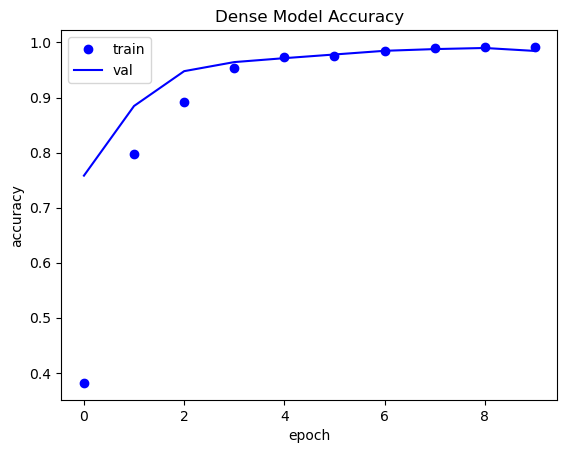

In [29]:
plt.plot(history_dense.history['accuracy'], 'bo')
plt.plot(history_dense.history['val_accuracy'], 'b')
plt.title('Dense Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

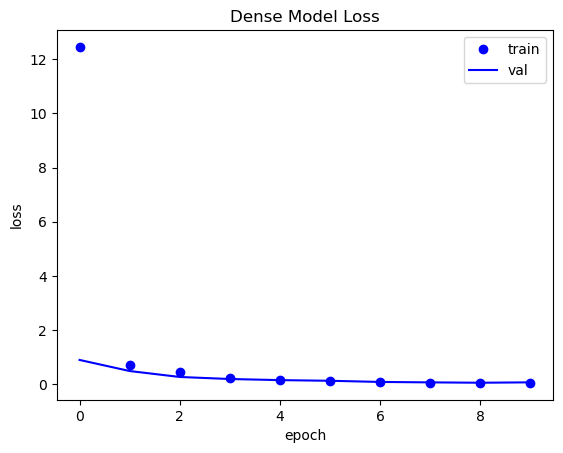

In [30]:
plt.plot(history_dense.history['loss'], 'bo')
plt.plot(history_dense.history['val_loss'], 'b')
plt.title('Dense Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper right')
plt.show()

In [31]:
model_dense.save('/kaggle/working/dense_model.h5')

# 6. <a name="6">**CNN model**</a>

In [32]:
train_gen = ImageDataGenerator(rescale=1./255)
train = train_gen.flow_from_directory('/kaggle/working/dataa/train', batch_size=64, target_size= (256, 256))

val_gen = ImageDataGenerator(rescale=1./255)
val = val_gen.flow_from_directory('/kaggle/working/dataa/val', batch_size=64, target_size= (256, 256))

Found 17934 images belonging to 10 classes.
Found 4490 images belonging to 10 classes.


In [33]:
model_CNN = models.Sequential()
model_CNN.add(Conv2D(32, (3, 3), activation='relu', input_shape=(256, 256, 3)))
model_CNN.add(MaxPooling2D((2, 2)))
model_CNN.add(Dropout(0.25))


model_CNN.add(Conv2D(64, (3, 3), activation='relu'))
model_CNN.add(MaxPooling2D((2, 2)))
model_CNN.add(Dropout(0.25))

model_CNN.add(Conv2D(128, (3, 3), activation='relu'))
model_CNN.add(MaxPooling2D((2, 2)))
model_CNN.add(Dropout(0.25))

model_CNN.add(Flatten())
# model.add(Dense(512, activation='relu'))
model_CNN.add(Dense(128, activation='relu'))
# model.add(Dense(64, activation='relu'))
model_CNN.add(Dropout(0.25))



model_CNN.add(Dense(10, activation='softmax'))

model_CNN.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 32)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 127, 127, 32)      0         
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 64)      18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 64)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 62, 62, 64)       

In [34]:
model_CNN.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['acc'])

In [35]:
from IPython.testing import test
history_CNN=model_CNN.fit(train ,epochs=10, batch_size=64,validation_data=val)

Epoch 1/10
281/281 [==============================] - 160s 543ms/step - loss: 1.2015 - acc: 0.5903 - val_loss: 0.2174 - val_acc: 0.9454
Epoch 2/10
281/281 [==============================] - 151s 538ms/step - loss: 0.2859 - acc: 0.9064 - val_loss: 0.0664 - val_acc: 0.9811
Epoch 3/10
281/281 [==============================] - 151s 537ms/step - loss: 0.1672 - acc: 0.9451 - val_loss: 0.0416 - val_acc: 0.9869
Epoch 4/10
281/281 [==============================] - 151s 539ms/step - loss: 0.1178 - acc: 0.9602 - val_loss: 0.0299 - val_acc: 0.9906
Epoch 5/10
281/281 [==============================] - 151s 538ms/step - loss: 0.0932 - acc: 0.9694 - val_loss: 0.0323 - val_acc: 0.9902
Epoch 6/10
281/281 [==============================] - 151s 538ms/step - loss: 0.0743 - acc: 0.9741 - val_loss: 0.0254 - val_acc: 0.9931
Epoch 7/10
281/281 [==============================] - 149s 530ms/step - loss: 0.0659 - acc: 0.9761 - val_loss: 0.0282 - val_acc: 0.9922
Epoch 8/10
281/281 [============================

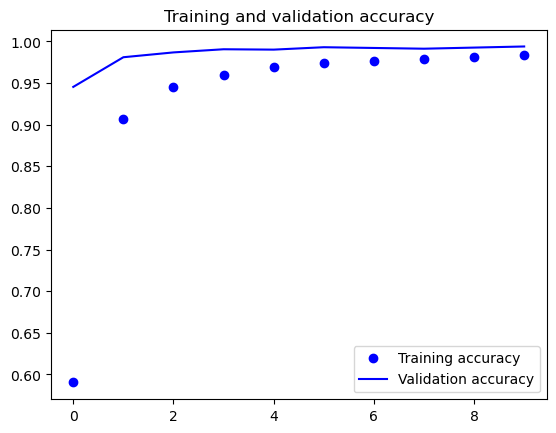

In [36]:
acc = history_CNN.history['acc']
val_acc = history_CNN.history['val_acc']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

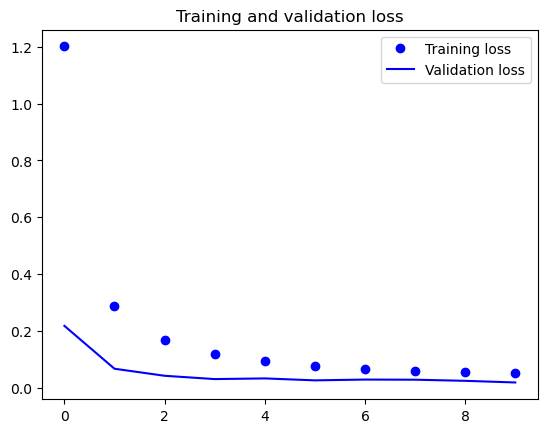

In [37]:
loss = history_CNN.history['loss']
val_loss = history_CNN.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [38]:
model_CNN.save('/kaggle/working/CNN_model.h5')

# 7. <a name="7">**Data Augmentation**</a>

## Preprocessing

In [39]:
batch_size = 32
datagen = ImageDataGenerator(rescale = 1/255,
                            zoom_range=0.05,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05, 
                            fill_mode="nearest")


train = datagen.flow_from_directory('/kaggle/working/dataa/train', batch_size=batch_size, target_size = (256, 256))

val_gen = ImageDataGenerator(rescale = 1/255)
val = val_gen.flow_from_directory('/kaggle/working/dataa/val', batch_size=batch_size, target_size = (256, 256))

Found 17934 images belonging to 10 classes.
Found 4490 images belonging to 10 classes.


In [40]:
for data_batch, labels_batch in train:
    print('data batch shape:', data_batch.shape)
    print('labels batch shape:', labels_batch.shape)
    break

data batch shape: (32, 256, 256, 3)
labels batch shape: (32, 10)


## Baseline Model

In [41]:
from keras import models
from keras import layers
from tensorflow.keras.layers import Dropout

model_DA = models.Sequential()
model_DA.add(layers.Conv2D(32,(3,3), activation='relu', name='Layer_1', input_shape=(256,256, 3)))
model_DA.add(layers.MaxPooling2D((2, 2)))
model_DA.add(layers.Conv2D(128,(3,3), activation='relu', name='Layer_2'))
model_DA.add(layers.MaxPooling2D((2, 2)))
model_DA.add(layers.Conv2D(128,(3,3), activation='relu', name='Layer_3'))
model_DA.add(layers.MaxPooling2D((2, 2)))
model_DA.add(layers.Conv2D(64,(3,3), activation='relu', name='Layer_4'))
model_DA.add(layers.MaxPooling2D((2, 2)))
model_DA.add(layers.Flatten())
model_DA.add(layers.Dense(512, activation='relu'))
model_DA.add(layers.Dropout(0.4))
model_DA.add(layers.Dense(10, activation='softmax'))

In [42]:
model_DA.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Layer_1 (Conv2D)            (None, 254, 254, 32)      896       
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 127, 127, 32)     0         
 2D)                                                             
                                                                 
 Layer_2 (Conv2D)            (None, 125, 125, 128)     36992     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 62, 62, 128)      0         
 2D)                                                             
                                                                 
 Layer_3 (Conv2D)            (None, 60, 60, 128)       147584    
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 30, 30, 128)     

In [43]:
model_DA.compile(optimizer='rmsprop',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

In [44]:
history_DA = model_DA.fit(
      train,
      epochs=20,
      steps_per_epoch = 150,
      validation_data=val,
      verbose=2,
      validation_steps=50)

Epoch 1/20
150/150 - 98s - loss: 2.1465 - accuracy: 0.3156 - val_loss: 0.9941 - val_accuracy: 0.6775 - 98s/epoch - 656ms/step
Epoch 2/20
150/150 - 94s - loss: 0.9721 - accuracy: 0.6765 - val_loss: 0.4785 - val_accuracy: 0.8413 - 94s/epoch - 630ms/step
Epoch 3/20
150/150 - 96s - loss: 0.5889 - accuracy: 0.8138 - val_loss: 0.2799 - val_accuracy: 0.9125 - 96s/epoch - 638ms/step
Epoch 4/20
150/150 - 94s - loss: 0.4288 - accuracy: 0.8626 - val_loss: 0.2006 - val_accuracy: 0.9388 - 94s/epoch - 629ms/step
Epoch 5/20
150/150 - 95s - loss: 0.3452 - accuracy: 0.8952 - val_loss: 0.2155 - val_accuracy: 0.9350 - 95s/epoch - 635ms/step
Epoch 6/20
150/150 - 94s - loss: 0.2599 - accuracy: 0.9227 - val_loss: 0.1503 - val_accuracy: 0.9531 - 94s/epoch - 627ms/step
Epoch 7/20
150/150 - 94s - loss: 0.2230 - accuracy: 0.9308 - val_loss: 0.1100 - val_accuracy: 0.9606 - 94s/epoch - 627ms/step
Epoch 8/20
150/150 - 94s - loss: 0.2239 - accuracy: 0.9319 - val_loss: 0.0705 - val_accuracy: 0.9819 - 94s/epoch - 627

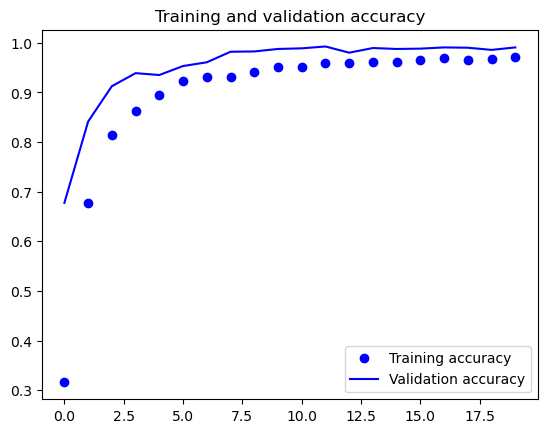

In [45]:
acc = history_DA.history['accuracy']
val_acc = history_DA.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

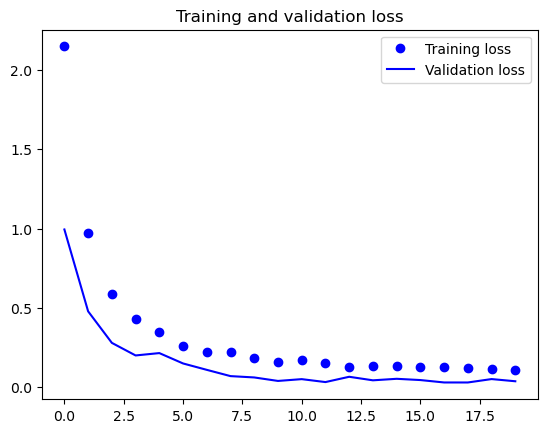

In [46]:
loss = history_DA.history['loss']
val_loss = history_DA.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [47]:
model_DA.save("/kaggle/working/Data_Augmentation_model.h5")

# 8. <a name="8">**Frozen model**</a>

In [48]:
batch_size = 32
datagen = ImageDataGenerator(preprocessing_function=preprocess_input,
                            zoom_range=0.05,
                            width_shift_range=0.05,
                            height_shift_range=0.05,
                            shear_range=0.05, 
                            fill_mode="nearest")


train = datagen.flow_from_directory('/kaggle/working/dataa/train', batch_size=batch_size, target_size = (256, 256))

val_gen = ImageDataGenerator(preprocessing_function = preprocess_input)
val = val_gen.flow_from_directory('/kaggle/working/dataa/val', batch_size=batch_size, target_size = (256, 256))

Found 17934 images belonging to 10 classes.
Found 4490 images belonging to 10 classes.


## Build NN

In [49]:
conv_base = VGG16(weights='imagenet',
                  include_top=False,
                  input_shape=(256, 256, 3))

conv_base.summary()

58900480/58889256 [==============================] - 0s 0us/step
Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                              

In [50]:
model_DL = models.Sequential()
model_DL.add(conv_base)
model_DL.add(layers.Flatten())
model_DL.add(layers.Dense(512, activation='relu'))
model_DL.add(layers.Dropout(0.35))
model_DL.add(layers.Dense(128, activation='relu'))
model_DL.add(layers.Dropout(0.35))
model_DL.add(layers.Dense(32, activation='relu'))
model_DL.add(layers.Dense(10, activation='softmax'))

model_DL.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 32)               

In [51]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model_DL.trainable_weights))

This is the number of trainable weights before freezing the conv base: 34


In [52]:
conv_base.trainable = False

In [53]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model_DL.trainable_weights))

This is the number of trainable weights before freezing the conv base: 8


In [54]:
model_DL.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 32)               

In [55]:
model_DL.compile(optimizer = optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
              metrics=['accuracy'])

history_DL = model_DL.fit(train,
                    epochs=20,
                    steps_per_epoch = 150,
                    validation_data=val,
                    verbose=1)

Epoch 1/20
150/150 [==============================] - 132s 853ms/step - loss: 5.2112 - accuracy: 0.2079 - val_loss: 1.3190 - val_accuracy: 0.5430
Epoch 2/20
150/150 [==============================] - 129s 862ms/step - loss: 2.1562 - accuracy: 0.3779 - val_loss: 1.0220 - val_accuracy: 0.6550
Epoch 3/20
150/150 [==============================] - 127s 845ms/step - loss: 1.6165 - accuracy: 0.4819 - val_loss: 0.7329 - val_accuracy: 0.7624
Epoch 4/20
150/150 [==============================] - 128s 851ms/step - loss: 1.2651 - accuracy: 0.5937 - val_loss: 0.5127 - val_accuracy: 0.8214
Epoch 5/20
150/150 [==============================] - 130s 865ms/step - loss: 1.0687 - accuracy: 0.6598 - val_loss: 0.3814 - val_accuracy: 0.8806
Epoch 6/20
150/150 [==============================] - 128s 854ms/step - loss: 0.8710 - accuracy: 0.7131 - val_loss: 0.2613 - val_accuracy: 0.9296
Epoch 7/20
150/150 [==============================] - 126s 843ms/step - loss: 0.7092 - accuracy: 0.7665 - val_loss: 0.1786 -

In [56]:
train_acc, train_loss = model_DL.evaluate(train)

561/561 [==============================] - 348s 619ms/step - loss: 0.0374 - accuracy: 0.9892


In [57]:
val_acc, val_loss = model_DL.evaluate(val)

141/141 [==============================] - 35s 248ms/step - loss: 0.0394 - accuracy: 0.9915


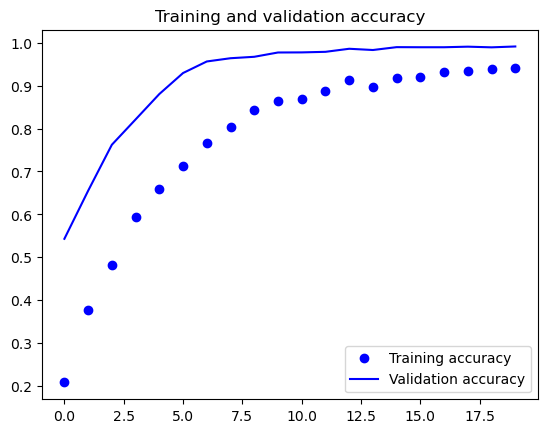

In [58]:
acc = history_DL.history['accuracy']
val_acc = history_DL.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

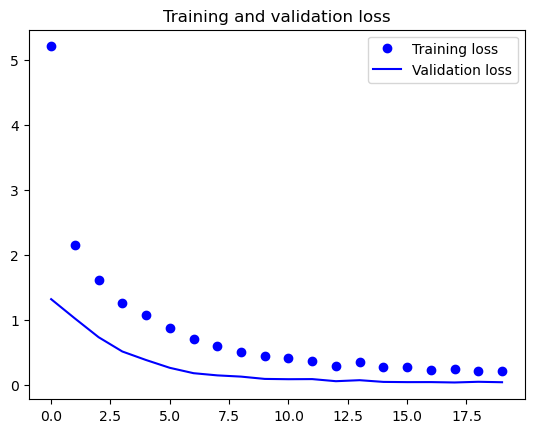

In [59]:
loss = history_DL.history['loss']
val_loss = history_DL.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [60]:
model_DL.save('/kaggle/working/driver_detection_Frozen_model.h5')
print("Saved model to kaggle")

Saved model to kaggle


# 9. <a name="9">**Fine Tuning**</a>

In [61]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [62]:
conv_base.trainable = True

set_trainable = False
for layer in conv_base.layers:
    if layer.name == 'conv5_block1_1_conv':
        set_trainable = True
    if set_trainable:
        layer.trainable = True
    else:
        layer.trainable = False

In [63]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 256, 256, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 256, 256, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 128, 128, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 128, 128, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 128, 128, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 64, 64, 128)       0     

In [64]:
model_copy= keras.models.clone_model(model_DL)
model_copy.build((None, 150, 150, 3))                                
model_copy.compile(optimizer = optimizers.Adam(learning_rate=0.0001),
                   loss='categorical_crossentropy',
                   metrics=['accuracy'])
model_copy.set_weights(model_DL.get_weights())

model_copy.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 32)               

In [65]:
model_DL.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 8, 8, 512)         14714688  
                                                                 
 flatten_4 (Flatten)         (None, 32768)             0         
                                                                 
 dense_12 (Dense)            (None, 512)               16777728  
                                                                 
 dropout_5 (Dropout)         (None, 512)               0         
                                                                 
 dense_13 (Dense)            (None, 128)               65664     
                                                                 
 dropout_6 (Dropout)         (None, 128)               0         
                                                                 
 dense_14 (Dense)            (None, 32)               

In [66]:
model_copy.compile(optimizer = optimizers.Adam(learning_rate=0.0001),
             loss='categorical_crossentropy',
              metrics=['accuracy'])

In [67]:
history_FT = model_copy.fit(
      train,
      steps_per_epoch=100,                 #train.n//train.batch_size,
      epochs=20,
      validation_data=val,
      validation_steps=50,                 #val.n//val.batch_size)
      verbose=1)

Epoch 1/20
100/100 [==============================] - 77s 762ms/step - loss: 0.2342 - accuracy: 0.9359 - val_loss: 0.0409 - val_accuracy: 0.9894
Epoch 2/20
100/100 [==============================] - 74s 743ms/step - loss: 0.2437 - accuracy: 0.9334 - val_loss: 0.0355 - val_accuracy: 0.9906
Epoch 3/20
100/100 [==============================] - 74s 743ms/step - loss: 0.2402 - accuracy: 0.9341 - val_loss: 0.0421 - val_accuracy: 0.9862
Epoch 4/20
100/100 [==============================] - 74s 737ms/step - loss: 0.2369 - accuracy: 0.9331 - val_loss: 0.0316 - val_accuracy: 0.9944
Epoch 5/20
100/100 [==============================] - 75s 753ms/step - loss: 0.2321 - accuracy: 0.9359 - val_loss: 0.0556 - val_accuracy: 0.9894
Epoch 6/20
100/100 [==============================] - 76s 762ms/step - loss: 0.1941 - accuracy: 0.9441 - val_loss: 0.0364 - val_accuracy: 0.9925
Epoch 7/20
100/100 [==============================] - 76s 760ms/step - loss: 0.2241 - accuracy: 0.9428 - val_loss: 0.0382 - val_ac

In [68]:
train_acc_FT, train_loss_FT = model_copy.evaluate(train)

561/561 [==============================] - 347s 619ms/step - loss: 0.0195 - accuracy: 0.9953


In [69]:
val_acc_FT, val_loss_FT = model_copy.evaluate(val)

141/141 [==============================] - 35s 245ms/step - loss: 0.0303 - accuracy: 0.9931


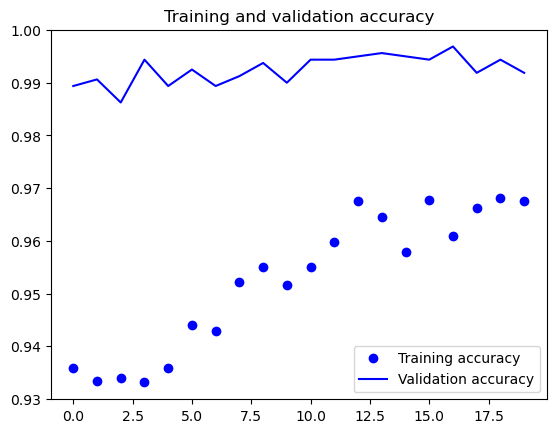

In [70]:
acc = history_FT.history['accuracy']
val_acc = history_FT.history['val_accuracy']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()

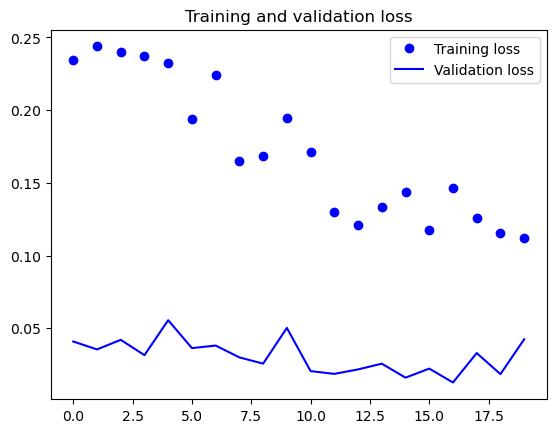

In [71]:
loss = history_FT.history['loss']
val_loss = history_FT.history['val_loss']

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

## Smoothing

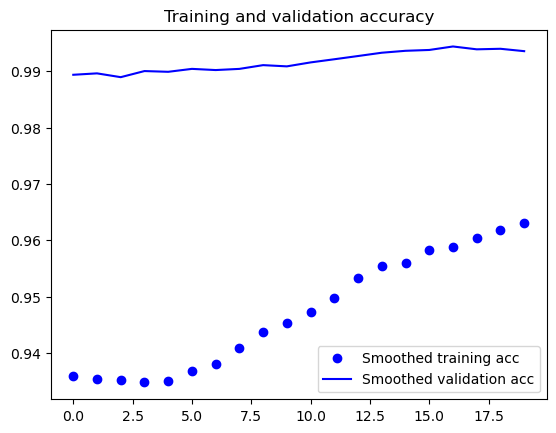

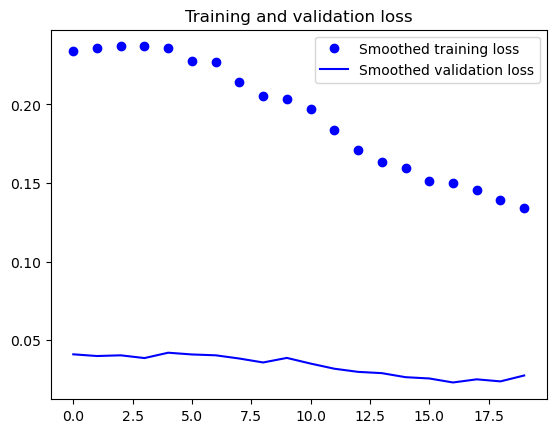

In [72]:
def smooth_curve(points, factor=0.8):
    smoothed_points = []
    for point in points:
        if smoothed_points:
            previous = smoothed_points[-1]
            smoothed_points.append(previous * factor + point * (1 - factor))
        else:
            smoothed_points.append(point)
    return smoothed_points

plt.plot(epochs,
         smooth_curve(acc), 'bo', label='Smoothed training acc')
plt.plot(epochs,
         smooth_curve(val_acc), 'b', label='Smoothed validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs,
         smooth_curve(loss), 'bo', label='Smoothed training loss')
plt.plot(epochs,
         smooth_curve(val_loss), 'b', label='Smoothed validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [73]:
model_copy.save('/kaggle/working/driver_detection_Fine_Tuning_model2.h5')
print("Saved model to kaggle")

Saved model to kaggle


In [74]:
# # dense
acc1=history_dense.history['accuracy'][-1]
vacc1=history_dense.history['val_accuracy'][-1]
loss1=history_dense.history['loss'][-2]
vloss1=history_dense.history['val_loss'][-2]


# CNN
acc2=history_CNN.history['acc'][-1]
vacc2=history_CNN.history['val_acc'][-1]
loss2=history_CNN.history['loss'][-2]
vloss2=history_CNN.history['val_loss'][-2]

# # Data Augmentation
acc3=history_DA.history['accuracy'][-1]
vacc3=history_DA.history['val_accuracy'][-1]
loss3=history_DA.history['loss'][-2]
vloss3=history_DA.history['val_loss'][-2]

# VGG16
acc4=history_DL.history['accuracy'][-1]
vacc4=history_DL.history['val_accuracy'][-1]
loss4=history_DL.history['loss'][-2]
vloss4=history_DL.history['val_loss'][-2]

# VGG16
acc5=history_FT.history['accuracy'][-1]
vacc5=history_FT.history['val_accuracy'][-1]
loss5=history_FT.history['loss'][-2]
vloss5=history_FT.history['val_loss'][-2]

In [75]:
results = pd.DataFrame([["Dense model",acc1*100,vacc1*100,loss1,vloss1],
                       ["CNN",acc2*100,vacc2*100,loss2,vloss2],
                       ["CNN_data_augmentation",acc3*100,vacc3*100,loss3,vloss3],
                       ["Transfer Learning model",acc4*100,vacc4*100,loss4,vloss4],
                       ["Transfer Learning model_FT",acc5*100,vacc5*100,loss5,vloss5]],
                       columns = ["Model","Training Accuracy %","Validation Accuracy %", 'Loss', 'Validation Loss'])
results

Model  Training Accuracy %  Validation Accuracy %  \
0                 Dense model            99.191481              98.463249   
1                         CNN            98.321623              99.398667   
2       CNN_data_augmentation            97.114176              99.062502   
3     Transfer Learning model            94.019240              99.153674   
4  Transfer Learning model_FT            96.749997              99.187499   

       Loss  Validation Loss  
0  0.048651         0.051274  
1  0.053435         0.023816  
2  0.118417         0.051909  
3  0.210551         0.046258  
4  0.115645         0.018516

# 10. <a name="10">**Testing**</a>

## Displaying some test images

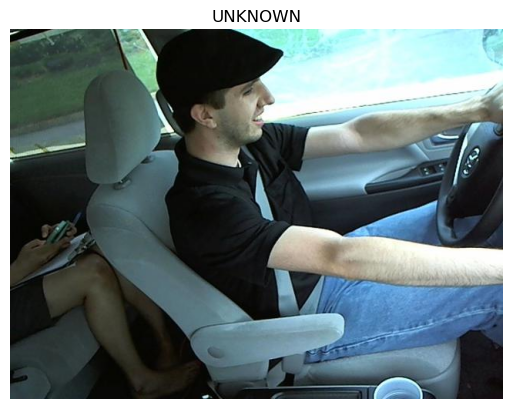

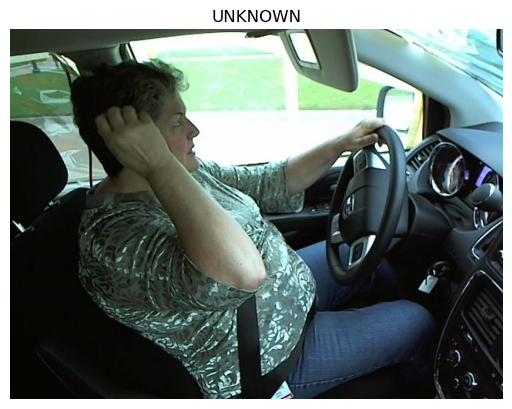

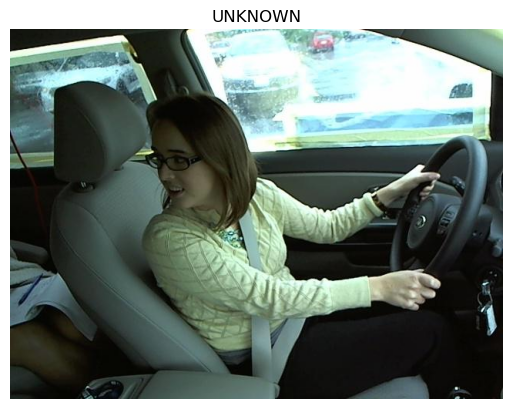

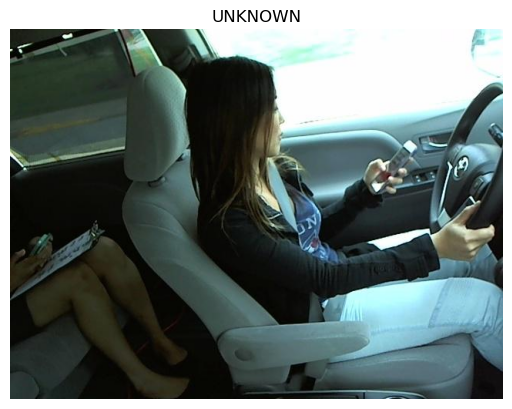

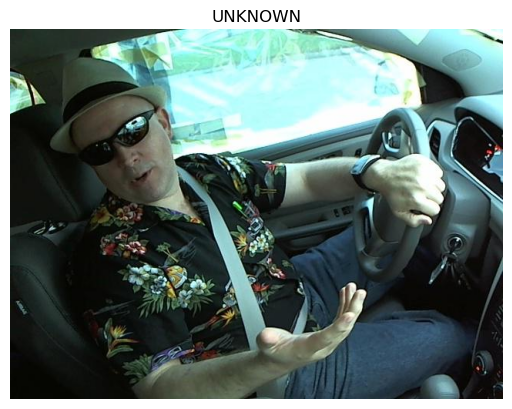

In [76]:
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_10.jpg")
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_100008.jpg")
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_100049.jpg")
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_100163.jpg")
Display("/kaggle/input/state-farm-distracted-driver-detection/imgs/test/img_100300.jpg")

## Load Test Data

In [77]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)

test = test_datagen.flow_from_directory('/kaggle/input/state-farm-distracted-driver-detection/imgs/.',
                                                  classes=['test'],
                                                  target_size=(256, 256),
                                                  batch_size = 20,
                                                  class_mode = None,
                                                  shuffle = False)

Found 79726 images belonging to 1 classes.


## Prediction

In [78]:
# # Load Model
# model = load_model('/kaggle/working/driver_detection_Fine_Tuning_model.h5')
# model.summary()  # As a reminder.

In [79]:
# Predict
Predict = model_copy.predict(test)

In [80]:
import os

img_names = []
for img_name in os.listdir('/kaggle/input/state-farm-distracted-driver-detection/imgs/test'):
    img_names.append(img_name)

img_names = np.sort(img_names)

In [81]:
from PIL import Image

tags = { 0: "safe driving",
        1: "texting - right",
        2: "talking on the phone - right",
        3: "texting - left",
        4: "talking on the phone - left",
        5: "operating the radio",
        6: "drinking",
        7: "reaching behind",
        8: "hair and makeup",
        9: "talking to passenger" }

def load_images_and_labels(data_path):
    x = []
    i = 0
    for img_name in img_names:

        img = cv2.imread(data_path + '/' + img_name)
        if img is not None:
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            img_array = Image.fromarray(img, 'RGB')
            img_rs = img_array.resize((150, 150))
            img_rs = np.array(img_rs)
            x.append(img_rs)
            i+=1
        if i ==100:
            break
    return x

In [82]:
x = load_images_and_labels('/kaggle/input/state-farm-distracted-driver-detection/imgs/test')

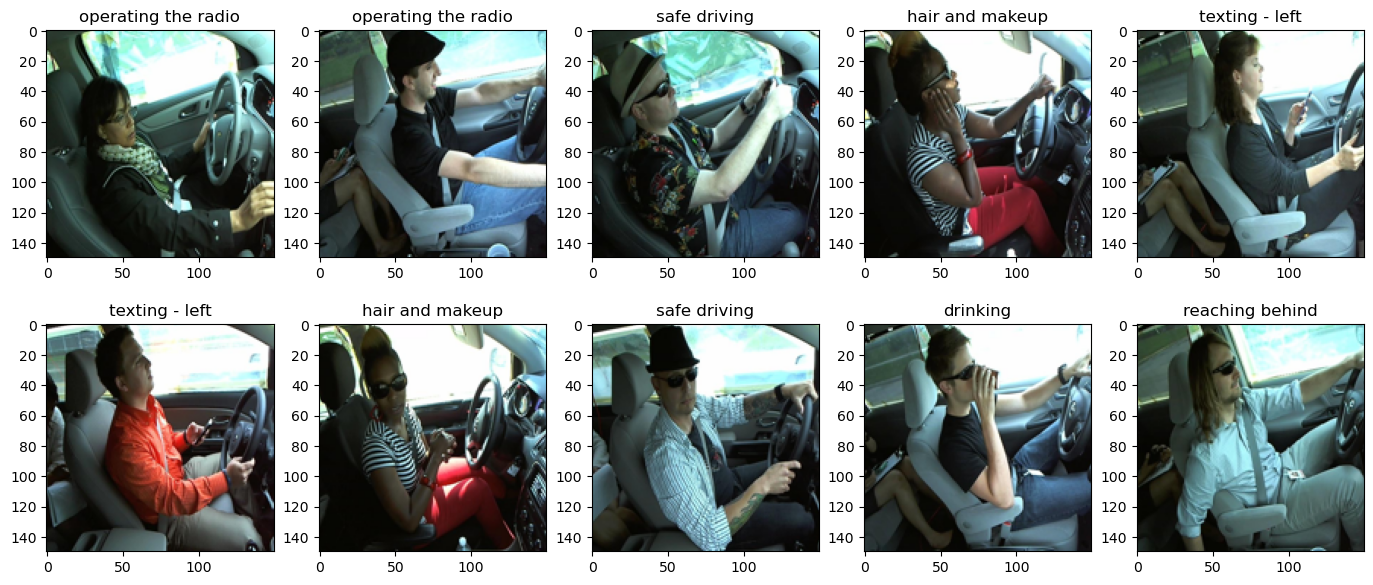

In [83]:
import random

plt.figure(figsize=(17, 7))

for i in range(0, 10, 1):
#     ind = random.randint(0, 8)
    plt.subplot(2, 5, i+1)
    plt.imshow(x[i])
    plt.title(tags[np.argmax(Predict[i])])

In [84]:
Predict[0]
np.argmax(Predict[0])

5

In [85]:
sample_sub = pd.read_csv("/kaggle/input/state-farm-distracted-driver-detection/sample_submission.csv")
sample_sub.head()

img   c0   c1   c2   c3   c4   c5   c6   c7   c8   c9
0       img_1.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
1      img_10.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
2     img_100.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
3    img_1000.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1
4  img_100000.jpg  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1  0.1

In [86]:
img = pd.DataFrame(img_names, columns = ['img'])
img.head(20)

img
0        img_1.jpg
1       img_10.jpg
2      img_100.jpg
3     img_1000.jpg
4   img_100000.jpg
5   img_100001.jpg
6   img_100002.jpg
7   img_100003.jpg
8   img_100004.jpg
9   img_100005.jpg
10  img_100007.jpg
11  img_100008.jpg
12  img_100009.jpg
13   img_10001.jpg
14  img_100010.jpg
15  img_100011.jpg
16  img_100012.jpg
17  img_100013.jpg
18  img_100014.jpg
19  img_100016.jpg

In [87]:
Pred = pd.DataFrame(Predict, columns = ['c0','c1','c2','c3','c4','c5','c6','c7','c8','c9'])
Pred.head()

c0            c1            c2            c3            c4  \
0  6.224794e-12  1.295061e-19  5.938035e-14  1.806463e-13  1.093938e-13   
1  6.213797e-03  1.343751e-07  1.213965e-05  1.283707e-04  1.945321e-04   
2  9.998378e-01  1.508205e-05  7.782822e-09  1.269724e-04  9.685506e-06   
3  2.753466e-20  7.234064e-24  1.539285e-12  1.305362e-28  5.390221e-21   
4  4.678912e-06  1.796089e-07  1.792887e-11  9.999379e-01  5.657180e-05   

             c5            c6            c7            c8            c9  
0  1.000000e+00  8.520449e-12  9.273719e-11  5.647619e-14  3.100537e-10  
1  9.903405e-01  1.093462e-05  2.519089e-03  7.300735e-06  5.731888e-04  
2  3.586140e-06  1.991370e-09  5.596714e-07  4.815721e-06  1.514756e-06  
3  1.126191e-18  1.387981e-12  9.106410e-19  1.000000e+00  5.666068e-18  
4  2.323218e-08  5.065248e-11  4.303764e-09  1.687289e-09  6.168215e-07

In [88]:
sub = pd.concat((img, Pred), axis = 1)
sub.head()

img            c0            c1            c2            c3  \
0       img_1.jpg  6.224794e-12  1.295061e-19  5.938035e-14  1.806463e-13   
1      img_10.jpg  6.213797e-03  1.343751e-07  1.213965e-05  1.283707e-04   
2     img_100.jpg  9.998378e-01  1.508205e-05  7.782822e-09  1.269724e-04   
3    img_1000.jpg  2.753466e-20  7.234064e-24  1.539285e-12  1.305362e-28   
4  img_100000.jpg  4.678912e-06  1.796089e-07  1.792887e-11  9.999379e-01   

             c4            c5            c6            c7            c8  \
0  1.093938e-13  1.000000e+00  8.520449e-12  9.273719e-11  5.647619e-14   
1  1.945321e-04  9.903405e-01  1.093462e-05  2.519089e-03  7.300735e-06   
2  9.685506e-06  3.586140e-06  1.991370e-09  5.596714e-07  4.815721e-06   
3  5.390221e-21  1.126191e-18  1.387981e-12  9.106410e-19  1.000000e+00   
4  5.657180e-05  2.323218e-08  5.065248e-11  4.303764e-09  1.687289e-09   

             c9  
0  3.100537e-10  
1  5.731888e-04  
2  1.514756e-06  
3  5.666068e-18  
4  6.168215e-07

In [89]:
sub.columns

Index(['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9'], dtype='object')

In [90]:
sub[['img', 'c0', 'c1', 'c2', 'c3', 'c4', 'c5', 'c6', 'c7', 'c8', 'c9']].to_csv(r'/kaggle/working/sub256.csv', index=False)

# 11. <a name="11">**Group names**</a>

## 1. Andrew Abd El-Messih Fakhry
## 2. Asmaa Mohammed Mansour
## 3. Farah Yousri Abdel meguid
## 4. Marwan Sadek Abdo
## 5. Zyad Samy Ahmed